In [21]:
import numpy as np
import pandas as pd
import pathlib
import os
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_pinball_loss,
)
import json

from utils_experiment import (
    load_data,
    get_model_list,
    plot_forecasts_analysis,
    rmse,
    pinball_loss,
    average_pinball_loss,
    plot_quantile_forecast
)

In [22]:




# for EXP_BASE in EXP_BASE_LIST:
#     EXP_MODEL_LIST = get_model_list(EXP_BASE)

#     for model_type in EXP_MODEL_LIST:
#         EXPERIMENT_NAME = f"{EXP_BASE}_{model_type}"
#         experiments.append(EXPERIMENT_NAME)

# experiments

Above is a list of all of the possible models, if you would like to limit which models are included:

In [23]:
exp_test_description = "Full_Report"
directory = f"/h/kupfersk/cfpr_2025/generate_forecasts/output/"

report_sim_dates = open("experiment_cutoff_dates.txt", 'r').read().split()

# report_sim_dates= report_sim_dates[1:-1]

target_categories = [
    'Bakery and cereal products (excluding baby food)',
     'Dairy products and eggs',
     'Fish, seafood and other marine products',
     'Food purchased from restaurants',
     'Food',
     'Fruit, fruit preparations and nuts',
     'Meat',
     'Other food products and non-alcoholic beverages',
     'Vegetables and vegetable preparations'
]


target_categories = [f"food_cpi: {col}" for col in target_categories]

start_years = [1986]
random_seed = 42

print("Target Categories:\n" + '\n'.join(target_categories))
print("Report Simulation Dates:\n" + '\n'.join(report_sim_dates))



file_path = "../data/processed_data/all_data_processed.csv"
all_data, foodprice_df, target_categories, all_covariates = load_data(target_categories, file_path)

Target Categories:
food_cpi: Bakery and cereal products (excluding baby food)
food_cpi: Dairy products and eggs
food_cpi: Fish, seafood and other marine products
food_cpi: Food purchased from restaurants
food_cpi: Food
food_cpi: Fruit, fruit preparations and nuts
food_cpi: Meat
food_cpi: Other food products and non-alcoholic beverages
food_cpi: Vegetables and vegetable preparations
Report Simulation Dates:
2018-07-01
2019-07-01
2020-07-01
2021-07-01
2022-07-01
2023-07-01


In [24]:
EXP_BASE_LIST = ["ag_local", "ag_global_cpi", "ag_global_with_covariates"]

ignore_list = [".csv",
               "ipynb",
#                 "ag_global_cpi_with_covariates_TemporalFusionTransformerModel",
                "llama",
#                 "gemini",
#                 "claude",
#                 "gpt",
#                "PatchTST",
               "exp2",
               "Mixtral",
               "restaurants",
               "DeepARModel_exp",
               "ChronosModel_exp",
               "PatchTSTModel_exp",
               "DLinearModel_exp",
               "exp7",
               "exp8",
               "corr",
               "economic",
#                "geopolitical",
               "human",
]

experiments = []
# for experiment_name in os.listdir(f"{directory}{exp_test_description}"):
#     if 'ipynb' not in experiment_name:
#         if '.csv' not in experiment_name:
#             if "ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp" not in experiment_name:
#                 if "llama" not in experiment_name:
#                     if "gemini" not in experiment_name:
#                         if "claude" not in experiment_name:
#                             if "gpt" not in experiment_name:



#                 experiments.append(experiment_name)

for experiment_name in os.listdir(f"{directory}{exp_test_description}"):
    if all(keyword not in experiment_name for keyword in ignore_list):
        experiments.append(experiment_name)


        # # Read the file and store the content in a list
        # llm_directory = '/h/kupfersk/cfpr_llm/Results_percentiles/Raw_data/'

        # with open((llm_directory + 'llm_models.txt'), 'r') as file:
        #     # Read all lines and strip any extra whitespace/newline characters
        #     loaded_list = [line.strip() for line in file]


        # experiments = experiments + loaded_list
experiments

['ag_local_DeepARModel',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel',
 'ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_',
 'ag_local_AutoETSModel',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_',
 'ag_global_all_PatchTSTModel',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_',
 'gemini-1.5-pro_report_True',
 'gpt-4o_report_True',
 'ag_global_all_TemporalFusionTransformerModel',
 'ag_local_SimpleFeedForwardModel',
 'gemini-1.5-pro_report_False',
 'ag_local_ChronosModel',
 'ag_global_all_SimpleFeedForwardModel',
 'ag_global_all_DeepARModel',
 'ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_',
 'ag_global_all_SimpleFeedForwardModel_exp5_climate_',
 'ag_local_AutoARIMAModel',
 'ag_local_SeasonalNaiveModel',
 'ag_local_NaiveMo

In [25]:
# EXP_BASE_LIST = ["ag_local", "ag_global_cpi", "ag_global_with_covariates"]


# experiments = []
# for experiment_name in os.listdir(f"{directory}{exp_test_description}"):
#     if 'ipynb' not in experiment_name:
#         if '.csv' not in experiment_name:
#     #     if "ag" in experiment_name:
#             if "exp" not in experiment_name:
#                 experiments.append(experiment_name)


#         # # Read the file and store the content in a list
#         # llm_directory = '/h/kupfersk/cfpr_llm/Results_percentiles/Raw_data/'

#         # with open((llm_directory + 'llm_models.txt'), 'r') as file:
#         #     # Read all lines and strip any extra whitespace/newline characters
#         #     loaded_list = [line.strip() for line in file]


#         # experiments = experiments + loaded_list
# experiments

## Evaluation Metrics


In [26]:
point_metrics = {
    "r2_score": r2_score,
    "mae": mean_absolute_error,
    "mape": mean_absolute_percentage_error,
    "mse": mean_squared_error,
    "rmse": rmse,
}

In [27]:
def compute_all_scores(report_sim_dates, study_metric="mape"):
    global forecast_df
    global actual_df
    results = []
        
        
    # Load the dictionary from the JSON file
    with open('target_category_dict_filt.json', 'r') as json_file:
        target_category_dict = json.load(json_file)

    for start_year in start_years:

        for EXPERIMENT_NAME in experiments:
            
            print(EXPERIMENT_NAME)
            if 'ag' in EXPERIMENT_NAME :
                if 'exp' in EXPERIMENT_NAME: 
                    general_experiment = f"exp{EXPERIMENT_NAME.split('_exp')[-1]}"
                    predicted_categories_in = target_category_dict[general_experiment]
                    # Drop items containing the word 'restaurant' or exactly 'food_cpi: Food'
                    predicted_categories = [item for item in predicted_categories_in if 'restaurant' not in item.lower() and item != 'food_cpi: Food']
                    
                else:
                    predicted_categories = target_categories
                
            else:
                predicted_categories = [
                                         'food_cpi: Bakery and cereal products (excluding baby food)',
                                         'food_cpi: Meat',
                                         'food_cpi: Vegetables and vegetable preparations'
                                    ]

            for category in predicted_categories:
                if "restaurant" in category:
                    continue 
                    
                scores = []

                for cutoff_date in report_sim_dates:

                    forecast_csv_path = f"./output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_{random_seed}/{cutoff_date}/forecasts/{category}.csv"
                    forecast_df = pd.read_csv(forecast_csv_path, index_col=0)
                    forecast_df.index = pd.to_datetime(forecast_df.index)

                    actual_df = foodprice_df[category].loc[
                        [
                            date
                            for date in forecast_df.index
                            if date in foodprice_df.index
                        ]
                    ]
                    
                    if report_sim_dates[-1] == cutoff_date:
                        forecast_df = forecast_df.iloc[:-1]
                        actual_df = actual_df.iloc[:-1]


                    if study_metric in point_metrics:
                        median_col = "q_0.5"
                        y_pred = forecast_df[median_col]
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            point_metrics[study_metric](y_true=y_true, y_pred=y_pred)
                        )

                    elif study_metric == "pinball_loss":
                        y_pred = forecast_df
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            average_pinball_loss(
                                y_true=y_true,
                                y_pred_quantiles=y_pred,
                                quantiles=[
                                    0.01,
                                    0.05,
                                    0.1,
                                    0.25,
                                    0.75,
                                    0.9,
                                    0.95,
                                    0.99,
                                ],
                            )
                        )

                mean_score = np.mean(scores)
                std_score = np.std(scores)

                results.append(
                    {   "year": start_year,
                        "experiment": EXPERIMENT_NAME,
                        "category": category,
                        "mean_score": mean_score,
                        "std_score": std_score,
                        "scores": scores
                    }
                )

    return pd.DataFrame(results)

def compute_scores_single_ensemble(report_sim_dates, ensemble_experiments, study_metric="mape"):
    """
    This function computes scores for an ensemble of experiments.
    
    Parameters:
    - report_sim_dates: List of simulation dates.
    - ensemble_experiments: A list of experiment names that form the ensemble.
    - study_metric: The metric to be used for scoring ('mape' or 'pinball_loss').
    
    Returns:
    - A DataFrame with results (mean and std scores).
    """
    global forecast_df
    global forecast_dfs
    global actual_df
    results = []

    for start_year in start_years:
        # Join experiment names to track which ensemble is being processed
        experiment_names = '+'.join(ensemble_experiments)
        print(f"Processing ensemble: {experiment_names}")

        if any(name in experiment_names for name in ['llama', 'claude', 'gpt', 'gemini']):
               predicted_categories = [
                'food_cpi: Bakery and cereal products (excluding baby food)',
                'food_cpi: Meat',
                'food_cpi: Vegetables and vegetable preparations'
            ]
        else:
            predicted_categories = target_categories


        for category in predicted_categories:
            scores = []

            for cutoff_date in report_sim_dates:

                # Collect the forecasts for each experiment in the ensemble
                forecast_dfs = []
                for exp_name in ensemble_experiments:
                    forecast_csv_path = f"./output/{exp_test_description}/{exp_name}/random_seed_{random_seed}/{cutoff_date}/forecasts/{category}.csv"
                    forecast_df = pd.read_csv(forecast_csv_path, index_col=0)
                    forecast_df = forecast_df[['q_0.05','q_0.95','q_0.5']]
                    forecast_df.index = pd.to_datetime(forecast_df.index)
                    forecast_df = forecast_df.loc[forecast_df.index<='2024-07-01']
                    forecast_dfs.append(forecast_df)

                # Aggregate the forecasts (mean ensemble)
#                 mean_forecast_values = np.sum([df.values / len(ensemble_experiments) for df in forecast_dfs], axis=0)
                
    
    
                # Concatenate DataFrames with alignment on index, filling missing values with NaN
                aligned_forecasts = pd.concat(forecast_dfs, axis=1, keys=range(len(forecast_dfs)))

                # Calculate the mean for each quantile, ignoring NaN values
                mean_q_0_05 = aligned_forecasts.xs('q_0.05', axis=1, level=1).mean(axis=1)
                mean_q_0_5 = aligned_forecasts.xs('q_0.5', axis=1, level=1).mean(axis=1)
                mean_q_0_95 = aligned_forecasts.xs('q_0.95', axis=1, level=1).mean(axis=1)

                # Combine the means back into a single DataFrame
                mean_forecast_df = pd.DataFrame({
                    'q_0.05': mean_q_0_05,
                    'q_0.5': mean_q_0_5,
                    'q_0.95': mean_q_0_95
                })    
                
                forecast_df = pd.DataFrame(mean_forecast_df, index=forecast_dfs[0].index, columns=forecast_dfs[0].columns)

                # Extract the actual values from the foodprice_df
                actual_df = foodprice_df[category].loc[
                    [
                        date
                        for date in forecast_df.index
                        if date in foodprice_df.index
                    ]
                ]

                # Handle the case where the forecast and actual data have different lengths
                if report_sim_dates[-1] == cutoff_date:
                    forecast_df = forecast_df.iloc[:-1]
                    actual_df = actual_df.iloc[:-1]
      

                # Score the aggregated forecast using the specified metric
                if study_metric in point_metrics:
                    median_col = "q_0.5"
                    y_pred = forecast_df[median_col]
                    y_true = actual_df
                    if len(y_pred) > len(y_true):
                        y_pred = y_pred[: len(y_true)]
                    scores.append(
                        point_metrics[study_metric](y_true=y_true, y_pred=y_pred)
                    )

            # Calculate mean and std deviation of the scores
            mean_score = np.mean(scores)
            std_score = np.std(scores)

            # Append the result for the current category and ensemble configuration
            results.append(
                {
                    "year": start_year,
                    "experiment": experiment_names,
                    "category": category,
                    "mean_score": mean_score,
                    "std_score": std_score,
                    "scores": scores
                }
            )

    # Return the result as a DataFrame
    return pd.DataFrame(results)



In [28]:
mape_df = compute_all_scores(report_sim_dates, 'mape')
mape_df

ag_local_DeepARModel
ag_global_cpi_with_covariates_TemporalFusionTransformerModel
ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_
ag_local_AutoETSModel
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_
ag_global_all_PatchTSTModel
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_
gemini-1.5-pro_report_True
gpt-4o_report_True
ag_global_all_TemporalFusionTransformerModel
ag_local_SimpleFeedForwardModel
gemini-1.5-pro_report_False
ag_local_ChronosModel
ag_global_all_SimpleFeedForwardModel
ag_global_all_DeepARModel
ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_
ag_global_all_SimpleFeedForwardModel_exp5_climate_
ag_local_AutoARIMAModel
ag_local_SeasonalNaiveModel
ag_local_NaiveModel
ag_local_PatchTSTModel
ag_global_all_TemporalFusionTransformerModel_exp5_manufactu

,year,experiment,category,mean_score,std_score,scores
0,1986,ag_local_DeepARModel,food_cpi: Bakery and cereal products (excludin...,0.036713,0.021999,"[0.011036732060852398, 0.019971501010228897, 0..."
1,1986,ag_local_DeepARModel,food_cpi: Dairy products and eggs,0.032611,0.016330,"[0.019867074994984066, 0.027847746093486305, 0..."
2,1986,ag_local_DeepARModel,"food_cpi: Fish, seafood and other marine products",0.022050,0.015371,"[0.010854690989193488, 0.011447317441345844, 0..."
3,1986,ag_local_DeepARModel,food_cpi: Food,0.033385,0.021728,"[0.01192819864460277, 0.015630026544120393, 0...."
4,1986,ag_local_DeepARModel,"food_cpi: Fruit, fruit preparations and nuts",0.038141,0.017945,"[0.02813726903135804, 0.02401235303421688, 0.0..."
...,...,...,...,...,...,...
225,1986,ag_local_TemporalFusionTransformerModel,food_cpi: Food,0.032911,0.020694,"[0.013975713709548246, 0.01231863941864048, 0...."
226,1986,ag_local_TemporalFusionTransformerModel,"food_cpi: Fruit, fruit preparations and nuts",0.046375,0.022073,"[0.02169973008505353, 0.03503221154346888, 0.0..."
227,1986,ag_local_TemporalFusionTransformerModel,food_cpi: Meat,0.031168,0.010951,"[0.016441312292381497, 0.04095060925211494, 0...."
228,1986,ag_local_TemporalFusionTransformerModel,food_cpi: Other food products and non-alcoholi...,0.031610,0.021170,"[0.012615555976243205, 0.011859104984157813, 0..."


In [29]:
from itertools import combinations
from tqdm import tqdm

all_exp_results = []

for category in foodprice_df.columns:
    print(f"Computing ensemble scores for: {category}")
    all_combinations = []

    # Iterate through combinations of experiments for the ensemble (from 1 to 5 experiments in ensemble)
    for r in range(1, 3):
        # Select top 10 experiments based on lowest mean_score for the specific category
        top_experiments = mape_df.loc[mape_df.category == category].sort_values('mean_score').head(10)['experiment']

        # Generate all combinations of the experiments for this category
        exp_combinations = combinations(top_experiments, r)
        all_combinations.extend(exp_combinations)

    exp_results = []
    
    # Iterate over each unique experiment configuration (combination of experiments)
    for exp_config in tqdm(set(all_combinations)):
        # Call the compute_scores_single_ensemble function with each combination of experiments
        exp_results.append(
            compute_scores_single_ensemble(
                report_sim_dates=report_sim_dates,  # Use your date range here
                ensemble_experiments=list(exp_config),  # Pass current combination of experiments
                study_metric="mape"  # or another metric if needed
            )
        )
    
    # Extend the results across all categories
    all_exp_results.extend(exp_results)

Computing ensemble scores for: food_cpi: Bakery and cereal products (excluding baby food)


  0%|          | 0/55 [00:00<?, ?it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


  4%|▎         | 2/55 [00:00<00:10,  4.84it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_False


  5%|▌         | 3/55 [00:00<00:10,  4.96it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_


  7%|▋         | 4/55 [00:00<00:10,  4.83it/s]

Processing ensemble: gpt-4o_report_True+ag_local_NaiveModel


  9%|▉         | 5/55 [00:01<00:10,  4.77it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 11%|█         | 6/55 [00:01<00:16,  2.90it/s]

Processing ensemble: ag_local_NaiveModel+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 13%|█▎        | 7/55 [00:02<00:20,  2.32it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+ag_global_all_ChronosModel


 15%|█▍        | 8/55 [00:02<00:17,  2.76it/s]

Processing ensemble: gemini-1.5-pro_report_False+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 16%|█▋        | 9/55 [00:02<00:14,  3.18it/s]

Processing ensemble: ag_global_all_ChronosModel+gpt-4o_report_False


 18%|█▊        | 10/55 [00:02<00:12,  3.52it/s]

Processing ensemble: ag_local_NaiveModel+gpt-4o_report_False


 22%|██▏       | 12/55 [00:03<00:10,  4.07it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 25%|██▌       | 14/55 [00:03<00:09,  4.43it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True
Processing ensemble: ag_global_all_ChronosModel+gemini-1.5-pro_report_False


 27%|██▋       | 15/55 [00:03<00:08,  4.47it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_all_ChronosModel


 29%|██▉       | 16/55 [00:04<00:13,  2.87it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_global_all_ChronosModel


 33%|███▎      | 18/55 [00:05<00:13,  2.75it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False
Processing ensemble: ag_local_NaiveModel


 35%|███▍      | 19/55 [00:05<00:13,  2.61it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_


 36%|███▋      | 20/55 [00:06<00:11,  2.99it/s]

Processing ensemble: ag_local_NaiveModel+gemini-1.5-pro_report_False


 38%|███▊      | 21/55 [00:06<00:10,  3.34it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 40%|████      | 22/55 [00:06<00:13,  2.51it/s]

Processing ensemble: gpt-4o_report_True+ag_global_all_ChronosModel


 44%|████▎     | 24/55 [00:07<00:09,  3.26it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False
Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 45%|████▌     | 25/55 [00:07<00:11,  2.52it/s]

Processing ensemble: ag_local_AutoETSModel+gpt-4o_report_True


 47%|████▋     | 26/55 [00:08<00:09,  2.91it/s]

Processing ensemble: ag_local_AutoETSModel


 49%|████▉     | 27/55 [00:08<00:10,  2.69it/s]

Processing ensemble: ag_local_AutoETSModel+gpt-4o_report_False


 51%|█████     | 28/55 [00:08<00:08,  3.05it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+gpt-4o_report_False


 55%|█████▍    | 30/55 [00:09<00:06,  3.96it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True
Processing ensemble: ag_local_AutoETSModel+ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_


 56%|█████▋    | 31/55 [00:09<00:08,  2.72it/s]

Processing ensemble: gpt-4o_report_True+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 58%|█████▊    | 32/55 [00:10<00:07,  3.08it/s]

Processing ensemble: ag_local_AutoETSModel+gemini-1.5-pro_report_False


 62%|██████▏   | 34/55 [00:10<00:05,  3.77it/s]

Processing ensemble: gpt-4o_report_True+gpt-4o_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_False+ag_local_NaiveModel


 64%|██████▎   | 35/55 [00:10<00:05,  3.96it/s]

Processing ensemble: gpt-4o_report_True+ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_


 65%|██████▌   | 36/55 [00:10<00:04,  4.10it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+gemini-1.5-pro_report_False


 67%|██████▋   | 37/55 [00:11<00:04,  4.23it/s]

Processing ensemble: gpt-4o_report_False+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 69%|██████▉   | 38/55 [00:11<00:03,  4.31it/s]

Processing ensemble: ag_global_all_ChronosModel


 73%|███████▎  | 40/55 [00:11<00:03,  4.05it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False
Processing ensemble: ag_global_all_ChronosModel+ag_local_NaiveModel


 76%|███████▋  | 42/55 [00:12<00:04,  3.18it/s]

Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_False+ag_local_AutoETSModel


 78%|███████▊  | 43/55 [00:13<00:03,  3.46it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 82%|████████▏ | 45/55 [00:13<00:02,  3.45it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True
Processing ensemble: gpt-4o_report_True


 85%|████████▌ | 47/55 [00:14<00:01,  4.32it/s]

Processing ensemble: gpt-4o_report_False+gemini-1.5-pro_report_False
Processing ensemble: gpt-4o_report_False


 87%|████████▋ | 48/55 [00:14<00:01,  4.90it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_


 89%|████████▉ | 49/55 [00:14<00:01,  3.71it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+ag_local_NaiveModel


 91%|█████████ | 50/55 [00:14<00:01,  3.92it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+ag_global_all_ChronosModel


 95%|█████████▍| 52/55 [00:15<00:00,  4.72it/s]

Processing ensemble: gemini-1.5-pro_report_False
Processing ensemble: ag_local_AutoETSModel+ag_local_NaiveModel


 96%|█████████▋| 53/55 [00:15<00:00,  2.95it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_local_NaiveModel


 98%|█████████▊| 54/55 [00:16<00:00,  2.36it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+ag_local_AutoETSModel


100%|██████████| 55/55 [00:16<00:00,  3.31it/s]


Computing ensemble scores for: food_cpi: Dairy products and eggs


  0%|          | 0/55 [00:00<?, ?it/s]

Processing ensemble: ag_local_TemporalFusionTransformerModel+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


  2%|▏         | 1/55 [00:00<00:33,  1.61it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


  4%|▎         | 2/55 [00:01<00:33,  1.57it/s]

Processing ensemble: ag_local_ChronosModel


  5%|▌         | 3/55 [00:01<00:28,  1.84it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_climate_


  7%|▋         | 4/55 [00:02<00:25,  2.01it/s]

Processing ensemble: ag_local_ChronosModel+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


  9%|▉         | 5/55 [00:02<00:27,  1.84it/s]

Processing ensemble: ag_local_ChronosModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 11%|█         | 6/55 [00:03<00:28,  1.74it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 13%|█▎        | 7/55 [00:04<00:28,  1.70it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_local_AutoETSModel


 15%|█▍        | 8/55 [00:04<00:28,  1.66it/s]

Processing ensemble: ag_local_ChronosModel+ag_local_SimpleFeedForwardModel


 16%|█▋        | 9/55 [00:05<00:28,  1.64it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 18%|█▊        | 10/55 [00:05<00:24,  1.81it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_local_SimpleFeedForwardModel


 20%|██        | 11/55 [00:06<00:25,  1.74it/s]

Processing ensemble: ag_local_AutoETSModel+ag_local_TemporalFusionTransformerModel


 22%|██▏       | 12/55 [00:06<00:25,  1.70it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_local_TemporalFusionTransformerModel


 24%|██▎       | 13/55 [00:07<00:25,  1.66it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 25%|██▌       | 14/55 [00:08<00:22,  1.81it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_local_SimpleFeedForwardModel


 27%|██▋       | 15/55 [00:08<00:23,  1.74it/s]

Processing ensemble: ag_local_SimpleFeedForwardModel


 29%|██▉       | 16/55 [00:09<00:20,  1.88it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_global_all_ChronosModel


 31%|███       | 17/55 [00:09<00:21,  1.79it/s]

Processing ensemble: ag_local_ChronosModel+ag_local_AutoETSModel


 33%|███▎      | 18/55 [00:10<00:21,  1.73it/s]

Processing ensemble: ag_local_ChronosModel+ag_local_TemporalFusionTransformerModel


 35%|███▍      | 19/55 [00:10<00:21,  1.69it/s]

Processing ensemble: ag_local_TemporalFusionTransformerModel+ag_global_all_SimpleFeedForwardModel_exp5_climate_


 36%|███▋      | 20/55 [00:11<00:20,  1.67it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 38%|███▊      | 21/55 [00:12<00:20,  1.66it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 40%|████      | 22/55 [00:12<00:19,  1.66it/s]

Processing ensemble: ag_local_TemporalFusionTransformerModel+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 42%|████▏     | 23/55 [00:13<00:19,  1.65it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_global_all_SimpleFeedForwardModel_exp5_climate_


 44%|████▎     | 24/55 [00:13<00:18,  1.64it/s]

Processing ensemble: ag_local_AutoETSModel


 45%|████▌     | 25/55 [00:14<00:16,  1.80it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 47%|████▋     | 26/55 [00:15<00:16,  1.74it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_climate_+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 49%|████▉     | 27/55 [00:15<00:16,  1.69it/s]

Processing ensemble: ag_local_TemporalFusionTransformerModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 51%|█████     | 28/55 [00:16<00:16,  1.67it/s]

Processing ensemble: ag_local_TemporalFusionTransformerModel


 53%|█████▎    | 29/55 [00:16<00:14,  1.83it/s]

Processing ensemble: ag_local_ChronosModel+ag_global_all_ChronosModel


 55%|█████▍    | 30/55 [00:17<00:14,  1.77it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 56%|█████▋    | 31/55 [00:17<00:13,  1.74it/s]

Processing ensemble: ag_local_TemporalFusionTransformerModel+ag_local_SimpleFeedForwardModel


 58%|█████▊    | 32/55 [00:18<00:13,  1.71it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 60%|██████    | 33/55 [00:19<00:13,  1.68it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_climate_+ag_local_SimpleFeedForwardModel


 62%|██████▏   | 34/55 [00:19<00:12,  1.67it/s]

Processing ensemble: ag_global_all_ChronosModel


 64%|██████▎   | 35/55 [00:20<00:10,  1.85it/s]

Processing ensemble: ag_local_ChronosModel+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 65%|██████▌   | 36/55 [00:20<00:10,  1.76it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_local_SimpleFeedForwardModel


 67%|██████▋   | 37/55 [00:21<00:10,  1.71it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_local_ChronosModel


 69%|██████▉   | 38/55 [00:22<00:10,  1.67it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_all_SimpleFeedForwardModel_exp5_climate_


 71%|███████   | 39/55 [00:22<00:09,  1.68it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_global_all_SimpleFeedForwardModel_exp5_climate_


 73%|███████▎  | 40/55 [00:23<00:08,  1.68it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 75%|███████▍  | 41/55 [00:23<00:07,  1.85it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_global_all_SimpleFeedForwardModel_exp5_climate_


 76%|███████▋  | 42/55 [00:24<00:07,  1.79it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_


 78%|███████▊  | 43/55 [00:24<00:06,  1.94it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 80%|████████  | 44/55 [00:25<00:05,  1.85it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 82%|████████▏ | 45/55 [00:25<00:05,  1.78it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_local_AutoETSModel


 84%|████████▎ | 46/55 [00:26<00:05,  1.72it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_local_SimpleFeedForwardModel


 85%|████████▌ | 47/55 [00:27<00:04,  1.70it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 87%|████████▋ | 48/55 [00:27<00:04,  1.69it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 89%|████████▉ | 49/55 [00:28<00:03,  1.66it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 91%|█████████ | 50/55 [00:28<00:03,  1.64it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_local_TemporalFusionTransformerModel


 93%|█████████▎| 51/55 [00:29<00:02,  1.62it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_global_all_SimpleFeedForwardModel_exp5_climate_


 95%|█████████▍| 52/55 [00:30<00:01,  1.62it/s]

Processing ensemble: ag_local_ChronosModel+ag_global_all_SimpleFeedForwardModel_exp5_climate_


 96%|█████████▋| 53/55 [00:30<00:01,  1.60it/s]

Processing ensemble: ag_local_AutoETSModel+ag_local_SimpleFeedForwardModel


 98%|█████████▊| 54/55 [00:31<00:00,  1.60it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_local_SimpleFeedForwardModel


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


Computing ensemble scores for: food_cpi: Fish, seafood and other marine products


  0%|          | 0/55 [00:00<?, ?it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_


  2%|▏         | 1/55 [00:00<00:34,  1.58it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_global_all_TemporalFusionTransformerModel_exp5_manufacturing_


  4%|▎         | 2/55 [00:01<00:33,  1.59it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


  5%|▌         | 3/55 [00:01<00:32,  1.60it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_


  7%|▋         | 4/55 [00:02<00:28,  1.81it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_


  9%|▉         | 5/55 [00:02<00:25,  1.97it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 11%|█         | 6/55 [00:03<00:23,  2.07it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_local_SimpleFeedForwardModel


 13%|█▎        | 7/55 [00:03<00:25,  1.89it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_manufacturing_


 15%|█▍        | 8/55 [00:04<00:23,  2.01it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 16%|█▋        | 9/55 [00:04<00:21,  2.10it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_


 18%|█▊        | 10/55 [00:05<00:23,  1.91it/s]

Processing ensemble: ag_local_SimpleFeedForwardModel


 20%|██        | 11/55 [00:05<00:21,  2.01it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 22%|██▏       | 12/55 [00:06<00:23,  1.85it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_manufacturing_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 24%|██▎       | 13/55 [00:06<00:23,  1.77it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_


 25%|██▌       | 14/55 [00:07<00:24,  1.70it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 27%|██▋       | 15/55 [00:08<00:24,  1.65it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_


 29%|██▉       | 16/55 [00:08<00:23,  1.64it/s]

Processing ensemble: ag_local_AutoETSModel


 31%|███       | 17/55 [00:09<00:21,  1.80it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_manufacturing_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_


 33%|███▎      | 18/55 [00:09<00:21,  1.76it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 35%|███▍      | 19/55 [00:10<00:20,  1.73it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_


 36%|███▋      | 20/55 [00:11<00:20,  1.70it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_+ag_global_all_TemporalFusionTransformerModel_exp5_manufacturing_


 38%|███▊      | 21/55 [00:11<00:20,  1.68it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 40%|████      | 22/55 [00:12<00:19,  1.65it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 42%|████▏     | 23/55 [00:13<00:19,  1.64it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_manufacturing_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 44%|████▎     | 24/55 [00:13<00:18,  1.64it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_+ag_local_SimpleFeedForwardModel


 45%|████▌     | 25/55 [00:14<00:18,  1.63it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 47%|████▋     | 26/55 [00:14<00:17,  1.61it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_manufacturing_+ag_local_SimpleFeedForwardModel


 49%|████▉     | 27/55 [00:15<00:17,  1.61it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 51%|█████     | 28/55 [00:16<00:16,  1.60it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_


 53%|█████▎    | 29/55 [00:16<00:14,  1.75it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 55%|█████▍    | 30/55 [00:17<00:14,  1.70it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_


 56%|█████▋    | 31/55 [00:17<00:14,  1.67it/s]

Processing ensemble: ag_local_SimpleFeedForwardModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 58%|█████▊    | 32/55 [00:18<00:13,  1.65it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_


 60%|██████    | 33/55 [00:19<00:13,  1.63it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 62%|██████▏   | 34/55 [00:19<00:11,  1.78it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 64%|██████▎   | 35/55 [00:20<00:11,  1.74it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_


 65%|██████▌   | 36/55 [00:20<00:11,  1.70it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_


 67%|██████▋   | 37/55 [00:21<00:10,  1.68it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 69%|██████▉   | 38/55 [00:21<00:10,  1.65it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_


 71%|███████   | 39/55 [00:22<00:09,  1.63it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_


 73%|███████▎  | 40/55 [00:23<00:09,  1.62it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 75%|███████▍  | 41/55 [00:23<00:08,  1.60it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_+ag_local_SimpleFeedForwardModel


 76%|███████▋  | 42/55 [00:24<00:08,  1.60it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_local_SimpleFeedForwardModel


 78%|███████▊  | 43/55 [00:25<00:07,  1.60it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_all_TemporalFusionTransformerModel_exp5_manufacturing_


 80%|████████  | 44/55 [00:25<00:06,  1.60it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 82%|████████▏ | 45/55 [00:26<00:06,  1.60it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_global_all_TemporalFusionTransformerModel_exp5_manufacturing_


 84%|████████▎ | 46/55 [00:27<00:05,  1.61it/s]

Processing ensemble: ag_local_SimpleFeedForwardModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_


 85%|████████▌ | 47/55 [00:27<00:04,  1.62it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_


 87%|████████▋ | 48/55 [00:28<00:04,  1.62it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 89%|████████▉ | 49/55 [00:28<00:03,  1.61it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 91%|█████████ | 50/55 [00:29<00:02,  1.77it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_


 93%|█████████▎| 51/55 [00:29<00:02,  1.72it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_+ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_


 95%|█████████▍| 52/55 [00:30<00:01,  1.69it/s]

Processing ensemble: ag_local_AutoETSModel+ag_local_SimpleFeedForwardModel


 96%|█████████▋| 53/55 [00:31<00:01,  1.66it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_local_SimpleFeedForwardModel


 98%|█████████▊| 54/55 [00:31<00:00,  1.65it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_manufacturing_+ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Computing ensemble scores for: food_cpi: Food purchased from restaurants


0it [00:00, ?it/s]


Computing ensemble scores for: food_cpi: Food


  0%|          | 0/55 [00:00<?, ?it/s]

Processing ensemble: ag_local_AutoARIMAModel+ag_local_AutoETSModel


  2%|▏         | 1/55 [00:00<00:33,  1.59it/s]

Processing ensemble: ag_local_ChronosModel


  4%|▎         | 2/55 [00:01<00:26,  1.97it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_global_all_DeepARModel


  5%|▌         | 3/55 [00:01<00:29,  1.77it/s]

Processing ensemble: ag_local_AutoARIMAModel+ag_local_TemporalFusionTransformerModel


  7%|▋         | 4/55 [00:02<00:30,  1.69it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_all_TemporalFusionTransformerModel


  9%|▉         | 5/55 [00:02<00:30,  1.64it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel+ag_local_NaiveModel


 11%|█         | 6/55 [00:03<00:30,  1.62it/s]

Processing ensemble: ag_local_NaiveModel+ag_global_all_DeepARModel


 13%|█▎        | 7/55 [00:04<00:29,  1.61it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel+ag_global_all_SimpleFeedForwardModel


 15%|█▍        | 8/55 [00:04<00:29,  1.61it/s]

Processing ensemble: ag_local_ChronosModel+ag_local_NaiveModel


 16%|█▋        | 9/55 [00:05<00:28,  1.62it/s]

Processing ensemble: ag_local_AutoETSModel+ag_local_TemporalFusionTransformerModel


 18%|█▊        | 10/55 [00:06<00:27,  1.62it/s]

Processing ensemble: ag_local_AutoARIMAModel


 20%|██        | 11/55 [00:06<00:24,  1.79it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_global_all_SimpleFeedForwardModel


 22%|██▏       | 12/55 [00:07<00:24,  1.73it/s]

Processing ensemble: ag_local_AutoARIMAModel+ag_global_all_DeepARModel


 24%|██▎       | 13/55 [00:07<00:24,  1.69it/s]

Processing ensemble: ag_local_NaiveModel+ag_global_all_SimpleFeedForwardModel


 25%|██▌       | 14/55 [00:08<00:24,  1.67it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 27%|██▋       | 15/55 [00:08<00:24,  1.65it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel+ag_local_TemporalFusionTransformerModel


 29%|██▉       | 16/55 [00:09<00:23,  1.65it/s]

Processing ensemble: ag_local_ChronosModel+ag_global_all_TemporalFusionTransformerModel


 31%|███       | 17/55 [00:10<00:23,  1.64it/s]

Processing ensemble: ag_local_NaiveModel


 33%|███▎      | 18/55 [00:10<00:20,  1.80it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 35%|███▍      | 19/55 [00:11<00:20,  1.74it/s]

Processing ensemble: ag_local_ChronosModel+ag_local_AutoETSModel


 36%|███▋      | 20/55 [00:11<00:20,  1.69it/s]

Processing ensemble: ag_local_ChronosModel+ag_local_TemporalFusionTransformerModel


 38%|███▊      | 21/55 [00:12<00:20,  1.66it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_all_DeepARModel


 40%|████      | 22/55 [00:13<00:20,  1.63it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel


 42%|████▏     | 23/55 [00:13<00:17,  1.79it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_local_ChronosModel


 44%|████▎     | 24/55 [00:14<00:17,  1.73it/s]

Processing ensemble: ag_local_AutoARIMAModel+ag_global_all_SimpleFeedForwardModel


 45%|████▌     | 25/55 [00:14<00:18,  1.67it/s]

Processing ensemble: ag_global_all_DeepARModel+ag_local_TemporalFusionTransformerModel


 47%|████▋     | 26/55 [00:15<00:17,  1.65it/s]

Processing ensemble: ag_local_AutoETSModel


 49%|████▉     | 27/55 [00:15<00:15,  1.83it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel+ag_global_all_DeepARModel


 51%|█████     | 28/55 [00:16<00:15,  1.78it/s]

Processing ensemble: ag_local_AutoARIMAModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 53%|█████▎    | 29/55 [00:17<00:15,  1.71it/s]

Processing ensemble: ag_local_TemporalFusionTransformerModel


 55%|█████▍    | 30/55 [00:17<00:13,  1.86it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_all_SimpleFeedForwardModel


 56%|█████▋    | 31/55 [00:18<00:13,  1.77it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel+ag_local_TemporalFusionTransformerModel


 58%|█████▊    | 32/55 [00:18<00:13,  1.72it/s]

Processing ensemble: ag_local_AutoETSModel+ag_local_NaiveModel


 60%|██████    | 33/55 [00:19<00:13,  1.68it/s]

Processing ensemble: ag_local_AutoARIMAModel+ag_local_ChronosModel


 62%|██████▏   | 34/55 [00:20<00:12,  1.66it/s]

Processing ensemble: ag_local_ChronosModel+ag_global_all_DeepARModel


 64%|██████▎   | 35/55 [00:20<00:12,  1.64it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel+ag_local_NaiveModel


 65%|██████▌   | 36/55 [00:21<00:11,  1.62it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_local_AutoARIMAModel


 67%|██████▋   | 37/55 [00:21<00:11,  1.62it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 69%|██████▉   | 38/55 [00:22<00:10,  1.61it/s]

Processing ensemble: ag_global_all_ChronosModel


 71%|███████   | 39/55 [00:22<00:08,  1.78it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel+ag_global_all_SimpleFeedForwardModel


 73%|███████▎  | 40/55 [00:23<00:08,  1.72it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_local_NaiveModel


 75%|███████▍  | 41/55 [00:24<00:08,  1.68it/s]

Processing ensemble: ag_global_all_DeepARModel


 76%|███████▋  | 42/55 [00:24<00:07,  1.83it/s]

Processing ensemble: ag_local_ChronosModel+ag_global_all_SimpleFeedForwardModel


 78%|███████▊  | 43/55 [00:25<00:06,  1.76it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel+ag_local_TemporalFusionTransformerModel


 80%|████████  | 44/55 [00:25<00:06,  1.72it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_global_all_TemporalFusionTransformerModel


 82%|████████▏ | 45/55 [00:26<00:05,  1.69it/s]

Processing ensemble: ag_global_all_DeepARModel+ag_global_all_SimpleFeedForwardModel


 84%|████████▎ | 46/55 [00:27<00:05,  1.66it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_local_AutoETSModel


 85%|████████▌ | 47/55 [00:27<00:04,  1.65it/s]

Processing ensemble: ag_local_ChronosModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 87%|████████▋ | 48/55 [00:28<00:04,  1.63it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel


 89%|████████▉ | 49/55 [00:28<00:03,  1.80it/s]

Processing ensemble: ag_local_AutoARIMAModel+ag_local_NaiveModel


 91%|█████████ | 50/55 [00:29<00:02,  1.74it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_local_TemporalFusionTransformerModel


 93%|█████████▎| 51/55 [00:30<00:02,  1.70it/s]

Processing ensemble: ag_local_NaiveModel+ag_local_TemporalFusionTransformerModel


 95%|█████████▍| 52/55 [00:30<00:01,  1.66it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 96%|█████████▋| 53/55 [00:31<00:01,  1.83it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel+ag_global_all_DeepARModel


 98%|█████████▊| 54/55 [00:31<00:00,  1.76it/s]

Processing ensemble: ag_local_AutoARIMAModel+ag_global_all_TemporalFusionTransformerModel


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


Computing ensemble scores for: food_cpi: Fruit, fruit preparations and nuts


  0%|          | 0/55 [00:00<?, ?it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_


  2%|▏         | 1/55 [00:00<00:32,  1.64it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


  4%|▎         | 2/55 [00:01<00:32,  1.63it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_


  5%|▌         | 3/55 [00:01<00:32,  1.62it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_climate_


  7%|▋         | 4/55 [00:02<00:27,  1.84it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


  9%|▉         | 5/55 [00:02<00:28,  1.76it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


 11%|█         | 6/55 [00:03<00:28,  1.70it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


 13%|█▎        | 7/55 [00:04<00:28,  1.69it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_


 15%|█▍        | 8/55 [00:04<00:25,  1.87it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


 16%|█▋        | 9/55 [00:05<00:25,  1.79it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_local_AutoETSModel


 18%|█▊        | 10/55 [00:05<00:26,  1.71it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_


 20%|██        | 11/55 [00:06<00:23,  1.86it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_local_AutoETSModel


 22%|██▏       | 12/55 [00:06<00:24,  1.78it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 24%|██▎       | 13/55 [00:07<00:21,  1.92it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_local_AutoETSModel


 25%|██▌       | 14/55 [00:07<00:22,  1.81it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_+ag_local_AutoETSModel


 27%|██▋       | 15/55 [00:08<00:22,  1.75it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


 29%|██▉       | 16/55 [00:09<00:22,  1.71it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 31%|███       | 17/55 [00:09<00:20,  1.86it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel+ag_local_AutoETSModel


 33%|███▎      | 18/55 [00:10<00:20,  1.78it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


 35%|███▍      | 19/55 [00:10<00:20,  1.73it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_local_AutoETSModel


 36%|███▋      | 20/55 [00:11<00:20,  1.68it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_+ag_local_AutoETSModel


 38%|███▊      | 21/55 [00:12<00:20,  1.66it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_


 40%|████      | 22/55 [00:12<00:19,  1.65it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


 42%|████▏     | 23/55 [00:13<00:17,  1.81it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 44%|████▎     | 24/55 [00:13<00:17,  1.74it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_


 45%|████▌     | 25/55 [00:14<00:17,  1.69it/s]

Processing ensemble: ag_local_AutoETSModel


 47%|████▋     | 26/55 [00:14<00:15,  1.83it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 49%|████▉     | 27/55 [00:15<00:15,  1.76it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 51%|█████     | 28/55 [00:16<00:15,  1.72it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 53%|█████▎    | 29/55 [00:16<00:15,  1.68it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_


 55%|█████▍    | 30/55 [00:17<00:15,  1.66it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_


 56%|█████▋    | 31/55 [00:17<00:14,  1.64it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_global_all_SimpleFeedForwardModel_exp5_climate_


 58%|█████▊    | 32/55 [00:18<00:14,  1.61it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 60%|██████    | 33/55 [00:18<00:12,  1.77it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_


 62%|██████▏   | 34/55 [00:19<00:12,  1.71it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_climate_+ag_local_AutoETSModel


 64%|██████▎   | 35/55 [00:20<00:11,  1.67it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_global_all_SimpleFeedForwardModel_exp5_climate_


 65%|██████▌   | 36/55 [00:20<00:11,  1.65it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_


 67%|██████▋   | 37/55 [00:21<00:11,  1.63it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_global_all_SimpleFeedForwardModel_exp5_climate_


 69%|██████▉   | 38/55 [00:22<00:10,  1.62it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_


 71%|███████   | 39/55 [00:22<00:09,  1.62it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 73%|███████▎  | 40/55 [00:23<00:09,  1.62it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_


 75%|███████▍  | 41/55 [00:23<00:08,  1.62it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_


 76%|███████▋  | 42/55 [00:24<00:07,  1.80it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_


 78%|███████▊  | 43/55 [00:24<00:06,  1.76it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 80%|████████  | 44/55 [00:25<00:06,  1.72it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_


 82%|████████▏ | 45/55 [00:26<00:05,  1.68it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel+ag_global_all_SimpleFeedForwardModel_exp5_climate_


 84%|████████▎ | 46/55 [00:26<00:05,  1.66it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_


 85%|████████▌ | 47/55 [00:27<00:04,  1.64it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 87%|████████▋ | 48/55 [00:28<00:04,  1.63it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_global_all_SimpleFeedForwardModel_exp5_climate_


 89%|████████▉ | 49/55 [00:28<00:03,  1.62it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_


 91%|█████████ | 50/55 [00:29<00:03,  1.61it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 93%|█████████▎| 51/55 [00:29<00:02,  1.61it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 95%|█████████▍| 52/55 [00:30<00:01,  1.78it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_


 96%|█████████▋| 53/55 [00:30<00:01,  1.72it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_


 98%|█████████▊| 54/55 [00:31<00:00,  1.69it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_+ag_global_all_SimpleFeedForwardModel_exp5_climate_


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


Computing ensemble scores for: food_cpi: Meat


  0%|          | 0/55 [00:00<?, ?it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


  2%|▏         | 1/55 [00:00<00:11,  4.57it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_+ag_local_AutoETSModel


  4%|▎         | 2/55 [00:00<00:23,  2.22it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+ag_local_PatchTSTModel


  5%|▌         | 3/55 [00:01<00:17,  2.89it/s]

Processing ensemble: ag_local_ChronosModel


  7%|▋         | 4/55 [00:01<00:19,  2.66it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


  9%|▉         | 5/55 [00:02<00:23,  2.15it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_


 11%|█         | 6/55 [00:02<00:18,  2.59it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_local_PatchTSTModel


 13%|█▎        | 7/55 [00:02<00:22,  2.15it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+ag_global_all_ChronosModel


 15%|█▍        | 8/55 [00:03<00:18,  2.59it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 18%|█▊        | 10/55 [00:03<00:15,  2.99it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False
Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_local_AutoETSModel


 20%|██        | 11/55 [00:04<00:18,  2.38it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_local_AutoETSModel


 22%|██▏       | 12/55 [00:05<00:20,  2.10it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 24%|██▎       | 13/55 [00:05<00:19,  2.18it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_+ag_global_all_ChronosModel


 25%|██▌       | 14/55 [00:06<00:20,  1.96it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 27%|██▋       | 15/55 [00:06<00:16,  2.37it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+ag_local_PatchTSTModel


 29%|██▉       | 16/55 [00:06<00:14,  2.76it/s]

Processing ensemble: ag_local_PatchTSTModel+ag_local_ChronosModel


 31%|███       | 17/55 [00:07<00:16,  2.28it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 33%|███▎      | 18/55 [00:07<00:18,  2.02it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+ag_local_ChronosModel


 35%|███▍      | 19/55 [00:07<00:14,  2.41it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_+ag_local_PatchTSTModel


 36%|███▋      | 20/55 [00:08<00:16,  2.09it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_global_all_ChronosModel


 38%|███▊      | 21/55 [00:09<00:17,  1.92it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_local_PatchTSTModel


 40%|████      | 22/55 [00:09<00:18,  1.82it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 42%|████▏     | 23/55 [00:10<00:18,  1.76it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 44%|████▎     | 24/55 [00:10<00:14,  2.14it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_local_ChronosModel


 45%|████▌     | 25/55 [00:11<00:15,  1.95it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_local_PatchTSTModel


 47%|████▋     | 26/55 [00:11<00:15,  1.82it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 49%|████▉     | 27/55 [00:12<00:15,  1.76it/s]

Processing ensemble: ag_local_AutoETSModel


 51%|█████     | 28/55 [00:12<00:14,  1.89it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 53%|█████▎    | 29/55 [00:13<00:11,  2.28it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 56%|█████▋    | 31/55 [00:13<00:09,  2.59it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True
Processing ensemble: ag_local_PatchTSTModel+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 58%|█████▊    | 32/55 [00:14<00:10,  2.18it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+ag_local_ChronosModel


 60%|██████    | 33/55 [00:14<00:08,  2.55it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 62%|██████▏   | 34/55 [00:15<00:09,  2.16it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_+ag_local_ChronosModel


 64%|██████▎   | 35/55 [00:16<00:10,  1.97it/s]

Processing ensemble: ag_global_all_ChronosModel


 67%|██████▋   | 37/55 [00:16<00:06,  2.63it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False
Processing ensemble: ag_local_ChronosModel+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 69%|██████▉   | 38/55 [00:17<00:07,  2.20it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_


 71%|███████   | 39/55 [00:17<00:07,  2.23it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 73%|███████▎  | 40/55 [00:17<00:05,  2.63it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_local_ChronosModel


 75%|███████▍  | 41/55 [00:18<00:06,  2.20it/s]

Processing ensemble: ag_local_PatchTSTModel+ag_local_AutoETSModel


 76%|███████▋  | 42/55 [00:19<00:06,  2.00it/s]

Processing ensemble: ag_local_AutoETSModel+ag_local_ChronosModel


 78%|███████▊  | 43/55 [00:19<00:06,  1.88it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 80%|████████  | 44/55 [00:20<00:06,  1.80it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 82%|████████▏ | 45/55 [00:20<00:04,  2.20it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+ag_local_AutoETSModel


 84%|████████▎ | 46/55 [00:20<00:03,  2.59it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 85%|████████▌ | 47/55 [00:21<00:03,  2.51it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_local_ChronosModel


 87%|████████▋ | 48/55 [00:21<00:03,  2.12it/s]

Processing ensemble: ag_local_PatchTSTModel


 89%|████████▉ | 49/55 [00:22<00:02,  2.17it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 91%|█████████ | 50/55 [00:22<00:02,  1.97it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_local_AutoETSModel


 93%|█████████▎| 51/55 [00:23<00:02,  1.85it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 95%|█████████▍| 52/55 [00:24<00:01,  1.76it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+ag_global_all_ChronosModel


 96%|█████████▋| 53/55 [00:24<00:00,  2.15it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_


 98%|█████████▊| 54/55 [00:24<00:00,  2.55it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+ag_local_AutoETSModel


100%|██████████| 55/55 [00:24<00:00,  2.21it/s]


Computing ensemble scores for: food_cpi: Other food products and non-alcoholic beverages


  0%|          | 0/55 [00:00<?, ?it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


  2%|▏         | 1/55 [00:00<00:33,  1.63it/s]

Processing ensemble: ag_local_ChronosModel


  4%|▎         | 2/55 [00:01<00:26,  1.97it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_climate_


  5%|▌         | 3/55 [00:01<00:24,  2.14it/s]

Processing ensemble: ag_local_ChronosModel+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


  7%|▋         | 4/55 [00:02<00:26,  1.92it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


  9%|▉         | 5/55 [00:02<00:27,  1.81it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


 11%|█         | 6/55 [00:03<00:28,  1.75it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


 13%|█▎        | 7/55 [00:03<00:27,  1.72it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


 15%|█▍        | 8/55 [00:04<00:27,  1.70it/s]

Processing ensemble: ag_local_ChronosModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 16%|█▋        | 9/55 [00:05<00:27,  1.68it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


 18%|█▊        | 10/55 [00:05<00:26,  1.67it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 20%|██        | 11/55 [00:06<00:26,  1.68it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 22%|██▏       | 12/55 [00:06<00:23,  1.82it/s]

Processing ensemble: ag_local_AutoETSModel+ag_local_TemporalFusionTransformerModel


 24%|██▎       | 13/55 [00:07<00:23,  1.76it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 25%|██▌       | 14/55 [00:07<00:21,  1.90it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_local_TemporalFusionTransformerModel


 27%|██▋       | 15/55 [00:08<00:22,  1.80it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


 29%|██▉       | 16/55 [00:09<00:22,  1.73it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_all_ChronosModel


 31%|███       | 17/55 [00:09<00:22,  1.70it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_global_all_ChronosModel


 33%|███▎      | 18/55 [00:10<00:22,  1.66it/s]

Processing ensemble: ag_local_ChronosModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


 35%|███▍      | 19/55 [00:10<00:21,  1.65it/s]

Processing ensemble: ag_local_ChronosModel+ag_local_TemporalFusionTransformerModel


 36%|███▋      | 20/55 [00:11<00:21,  1.63it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_local_TemporalFusionTransformerModel


 38%|███▊      | 21/55 [00:12<00:20,  1.63it/s]

Processing ensemble: ag_local_TemporalFusionTransformerModel+ag_global_all_SimpleFeedForwardModel_exp5_climate_


 40%|████      | 22/55 [00:12<00:20,  1.62it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


 42%|████▏     | 23/55 [00:13<00:17,  1.78it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 44%|████▎     | 24/55 [00:13<00:18,  1.71it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 45%|████▌     | 25/55 [00:14<00:17,  1.67it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_local_ChronosModel


 47%|████▋     | 26/55 [00:15<00:17,  1.63it/s]

Processing ensemble: ag_local_TemporalFusionTransformerModel+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 49%|████▉     | 27/55 [00:15<00:17,  1.62it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_global_all_SimpleFeedForwardModel_exp5_climate_


 51%|█████     | 28/55 [00:16<00:16,  1.62it/s]

Processing ensemble: ag_local_AutoETSModel


 53%|█████▎    | 29/55 [00:16<00:14,  1.79it/s]

Processing ensemble: ag_local_TemporalFusionTransformerModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 55%|█████▍    | 30/55 [00:17<00:14,  1.74it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_


 56%|█████▋    | 31/55 [00:18<00:14,  1.70it/s]

Processing ensemble: ag_local_TemporalFusionTransformerModel


 58%|█████▊    | 32/55 [00:18<00:12,  1.84it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 60%|██████    | 33/55 [00:19<00:12,  1.77it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 62%|██████▏   | 34/55 [00:19<00:12,  1.72it/s]

Processing ensemble: ag_global_all_ChronosModel


 64%|██████▎   | 35/55 [00:20<00:10,  1.87it/s]

Processing ensemble: ag_local_ChronosModel+ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 65%|██████▌   | 36/55 [00:20<00:10,  1.79it/s]

Processing ensemble: ag_local_TemporalFusionTransformerModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


 67%|██████▋   | 37/55 [00:21<00:10,  1.74it/s]

Processing ensemble: ag_local_AutoETSModel+ag_local_ChronosModel


 69%|██████▉   | 38/55 [00:21<00:10,  1.70it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_local_ChronosModel


 71%|███████   | 39/55 [00:22<00:09,  1.67it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


 73%|███████▎  | 40/55 [00:23<00:09,  1.66it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_all_SimpleFeedForwardModel_exp5_climate_


 75%|███████▍  | 41/55 [00:23<00:08,  1.64it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_


 76%|███████▋  | 42/55 [00:24<00:07,  1.81it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_global_all_SimpleFeedForwardModel_exp5_climate_


 78%|███████▊  | 43/55 [00:24<00:06,  1.74it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_global_all_SimpleFeedForwardModel_exp5_climate_


 80%|████████  | 44/55 [00:25<00:06,  1.71it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_+ag_global_all_SimpleFeedForwardModel_exp5_climate_


 82%|████████▏ | 45/55 [00:26<00:05,  1.69it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


 84%|████████▎ | 46/55 [00:26<00:05,  1.65it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_


 85%|████████▌ | 47/55 [00:27<00:04,  1.80it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 87%|████████▋ | 48/55 [00:27<00:04,  1.73it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 89%|████████▉ | 49/55 [00:28<00:03,  1.69it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 91%|█████████ | 50/55 [00:29<00:03,  1.65it/s]

Processing ensemble: ag_local_AutoETSModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 93%|█████████▎| 51/55 [00:29<00:02,  1.64it/s]

Processing ensemble: ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 95%|█████████▍| 52/55 [00:30<00:01,  1.63it/s]

Processing ensemble: ag_global_all_ChronosModel+ag_local_TemporalFusionTransformerModel


 96%|█████████▋| 53/55 [00:30<00:01,  1.63it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp5_climate_+ag_global_all_SimpleFeedForwardModel_exp5_climate_


 98%|█████████▊| 54/55 [00:31<00:00,  1.62it/s]

Processing ensemble: ag_local_ChronosModel+ag_global_all_SimpleFeedForwardModel_exp5_climate_


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


Computing ensemble scores for: food_cpi: Vegetables and vegetable preparations


  0%|          | 0/55 [00:00<?, ?it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_+ag_local_DLinearModel


  2%|▏         | 1/55 [00:00<00:33,  1.59it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_+ag_local_SimpleFeedForwardModel


  4%|▎         | 2/55 [00:01<00:32,  1.62it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_local_DLinearModel


  5%|▌         | 3/55 [00:01<00:31,  1.63it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


  7%|▋         | 4/55 [00:02<00:31,  1.61it/s]

Processing ensemble: ag_global_all_DeepARModel+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


  9%|▉         | 5/55 [00:03<00:31,  1.60it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel+ag_local_DLinearModel


 11%|█         | 6/55 [00:03<00:30,  1.60it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 13%|█▎        | 7/55 [00:04<00:29,  1.60it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


 15%|█▍        | 8/55 [00:04<00:29,  1.61it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_


 16%|█▋        | 9/55 [00:05<00:26,  1.77it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 18%|█▊        | 10/55 [00:05<00:23,  1.91it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_local_DeepARModel


 20%|██        | 11/55 [00:06<00:24,  1.79it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_+ag_local_DeepARModel


 22%|██▏       | 12/55 [00:07<00:24,  1.74it/s]

Processing ensemble: ag_local_PatchTSTModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 24%|██▎       | 13/55 [00:07<00:24,  1.70it/s]

Processing ensemble: ag_local_SimpleFeedForwardModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


 25%|██▌       | 14/55 [00:08<00:24,  1.67it/s]

Processing ensemble: ag_global_all_DeepARModel+ag_local_DLinearModel


 27%|██▋       | 15/55 [00:08<00:24,  1.64it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 29%|██▉       | 16/55 [00:09<00:21,  1.81it/s]

Processing ensemble: ag_global_all_DeepARModel+ag_local_SimpleFeedForwardModel


 31%|███       | 17/55 [00:10<00:21,  1.75it/s]

Processing ensemble: ag_local_SimpleFeedForwardModel+ag_local_DeepARModel


 33%|███▎      | 18/55 [00:10<00:21,  1.70it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_+ag_local_DLinearModel


 35%|███▍      | 19/55 [00:11<00:21,  1.67it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel+ag_local_DeepARModel


 36%|███▋      | 20/55 [00:11<00:21,  1.66it/s]

Processing ensemble: ag_local_DLinearModel


 38%|███▊      | 21/55 [00:12<00:18,  1.82it/s]

Processing ensemble: ag_local_SimpleFeedForwardModel


 40%|████      | 22/55 [00:12<00:16,  1.96it/s]

Processing ensemble: ag_global_all_DeepARModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


 42%|████▏     | 23/55 [00:13<00:17,  1.85it/s]

Processing ensemble: ag_local_DLinearModel+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 44%|████▎     | 24/55 [00:13<00:17,  1.77it/s]

Processing ensemble: ag_local_DeepARModel+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 45%|████▌     | 25/55 [00:14<00:17,  1.71it/s]

Processing ensemble: ag_local_PatchTSTModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_


 47%|████▋     | 26/55 [00:15<00:17,  1.67it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_+ag_local_DeepARModel


 49%|████▉     | 27/55 [00:15<00:16,  1.65it/s]

Processing ensemble: ag_local_PatchTSTModel+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 51%|█████     | 28/55 [00:16<00:16,  1.63it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


 53%|█████▎    | 29/55 [00:16<00:14,  1.79it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_global_all_DeepARModel


 55%|█████▍    | 30/55 [00:17<00:14,  1.73it/s]

Processing ensemble: ag_global_all_DeepARModel+ag_local_DeepARModel


 56%|█████▋    | 31/55 [00:18<00:14,  1.71it/s]

Processing ensemble: ag_local_PatchTSTModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_


 58%|█████▊    | 32/55 [00:18<00:13,  1.69it/s]

Processing ensemble: ag_local_DeepARModel


 60%|██████    | 33/55 [00:19<00:11,  1.86it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_+ag_global_all_DeepARModel


 62%|██████▏   | 34/55 [00:19<00:11,  1.79it/s]

Processing ensemble: ag_local_DeepARModel+ag_local_DLinearModel


 64%|██████▎   | 35/55 [00:20<00:11,  1.73it/s]

Processing ensemble: ag_local_PatchTSTModel+ag_local_DLinearModel


 65%|██████▌   | 36/55 [00:20<00:11,  1.69it/s]

Processing ensemble: ag_local_PatchTSTModel+ag_local_SimpleFeedForwardModel


 67%|██████▋   | 37/55 [00:21<00:10,  1.68it/s]

Processing ensemble: ag_local_PatchTSTModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_


 69%|██████▉   | 38/55 [00:22<00:10,  1.67it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 71%|███████   | 39/55 [00:22<00:09,  1.65it/s]

Processing ensemble: ag_local_PatchTSTModel+ag_local_DeepARModel


 73%|███████▎  | 40/55 [00:23<00:09,  1.63it/s]

Processing ensemble: ag_global_all_DeepARModel


 75%|███████▍  | 41/55 [00:23<00:07,  1.78it/s]

Processing ensemble: ag_local_SimpleFeedForwardModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 76%|███████▋  | 42/55 [00:24<00:07,  1.73it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 78%|███████▊  | 43/55 [00:25<00:07,  1.70it/s]

Processing ensemble: ag_local_PatchTSTModel


 80%|████████  | 44/55 [00:25<00:06,  1.83it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_


 82%|████████▏ | 45/55 [00:26<00:05,  1.76it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 84%|████████▎ | 46/55 [00:26<00:05,  1.70it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 85%|████████▌ | 47/55 [00:27<00:04,  1.67it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 87%|████████▋ | 48/55 [00:28<00:04,  1.65it/s]

Processing ensemble: ag_global_all_DeepARModel+ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 89%|████████▉ | 49/55 [00:28<00:03,  1.63it/s]

Processing ensemble: ag_local_SimpleFeedForwardModel+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 91%|█████████ | 50/55 [00:29<00:03,  1.60it/s]

Processing ensemble: ag_local_PatchTSTModel+ag_global_all_DeepARModel


 93%|█████████▎| 51/55 [00:29<00:02,  1.60it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel+ag_global_all_TemporalFusionTransformerModel_exp1_llm_


 95%|█████████▍| 52/55 [00:30<00:01,  1.59it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel


 96%|█████████▋| 53/55 [00:31<00:01,  1.76it/s]

Processing ensemble: ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_+ag_local_SimpleFeedForwardModel


 98%|█████████▊| 54/55 [00:31<00:00,  1.73it/s]

Processing ensemble: ag_local_SimpleFeedForwardModel+ag_local_DLinearModel


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


In [30]:
forecast_dfs

[               q_0.05     q_0.95      q_0.5
 timestamp                                  
 2023-08-01  170.76857  200.37918  185.57387
 2023-09-01  168.34060  202.55899  185.44980
 2023-10-01  166.04013  202.36719  184.20366
 2023-11-01  169.74280  207.59102  188.66692
 2023-12-01  172.98819  210.78514  191.88667
 2024-01-01  171.16333  210.93544  191.04940
 2024-02-01  170.27199  210.69273  190.48236
 2024-03-01  167.89520  209.91609  188.90565
 2024-04-01  166.25398  208.31955  187.28677
 2024-05-01  167.93817  209.59952  188.76884
 2024-06-01  168.74518  210.23633  189.49075
 2024-07-01  167.78201  209.50670  188.64435,
                q_0.05     q_0.95      q_0.5
 timestamp                                  
 2023-08-01  169.69768  186.32802  178.01285
 2023-09-01  159.27820  179.69221  169.48520
 2023-10-01  150.56099  179.28522  164.92310
 2023-11-01  167.21521  190.40650  178.81085
 2023-12-01  167.11030  196.60242  181.85637
 2024-01-01  176.35014  205.93390  191.14203
 2024-02-

In [31]:
forecast_dfs

[               q_0.05     q_0.95      q_0.5
 timestamp                                  
 2023-08-01  170.76857  200.37918  185.57387
 2023-09-01  168.34060  202.55899  185.44980
 2023-10-01  166.04013  202.36719  184.20366
 2023-11-01  169.74280  207.59102  188.66692
 2023-12-01  172.98819  210.78514  191.88667
 2024-01-01  171.16333  210.93544  191.04940
 2024-02-01  170.27199  210.69273  190.48236
 2024-03-01  167.89520  209.91609  188.90565
 2024-04-01  166.25398  208.31955  187.28677
 2024-05-01  167.93817  209.59952  188.76884
 2024-06-01  168.74518  210.23633  189.49075
 2024-07-01  167.78201  209.50670  188.64435,
                q_0.05     q_0.95      q_0.5
 timestamp                                  
 2023-08-01  169.69768  186.32802  178.01285
 2023-09-01  159.27820  179.69221  169.48520
 2023-10-01  150.56099  179.28522  164.92310
 2023-11-01  167.21521  190.40650  178.81085
 2023-12-01  167.11030  196.60242  181.85637
 2024-01-01  176.35014  205.93390  191.14203
 2024-02-

In [32]:
# all_combinations
mape_df = pd.concat(all_exp_results).reset_index(drop=True)

overall_mape = mape_df
overall_mape = overall_mape.drop(columns='scores')
overall_mape = overall_mape.drop_duplicates()

In [33]:
overall_mape.loc[overall_mape.category == 'food_cpi: Bakery and cereal products (excluding baby food)'].sort_values('mean_score')

,year,experiment,category,mean_score,std_score
177,1986,claude-3-5-sonnet-20240620_report_False,food_cpi: Bakery and cereal products (excludin...,0.028999,0.016868
228,1986,claude-3-5-sonnet-20240620_report_False+ag_glo...,food_cpi: Bakery and cereal products (excludin...,0.029314,0.020991
192,1986,claude-3-5-sonnet-20240620_report_False+ag_loc...,food_cpi: Bakery and cereal products (excludin...,0.029778,0.021896
204,1986,claude-3-5-sonnet-20240620_report_False+claude...,food_cpi: Bakery and cereal products (excludin...,0.030017,0.016140
2292,1986,claude-3-5-sonnet-20240620_report_True+claude-...,food_cpi: Bakery and cereal products (excludin...,0.030017,0.016140
...,...,...,...,...,...
3426,1986,ag_local_PatchTSTModel+ag_local_DLinearModel,food_cpi: Bakery and cereal products (excludin...,0.050171,0.033130
2571,1986,ag_local_PatchTSTModel,food_cpi: Bakery and cereal products (excludin...,0.052984,0.032673
3597,1986,ag_local_SimpleFeedForwardModel+ag_local_DLine...,food_cpi: Bakery and cereal products (excludin...,0.053084,0.038383
3435,1986,ag_local_PatchTSTModel+ag_local_SimpleFeedForw...,food_cpi: Bakery and cereal products (excludin...,0.053998,0.039150


In [34]:
best_results_year = []

for category in target_categories:
    # Filter rows for the current category
    category_rows = overall_mape.loc[overall_mape.category == category]
    
    # Get the top 5 experiments with the lowest mean_score
    top_rows = category_rows.nsmallest(10, "mean_score")
    
    # Append the results to the list
    for _, row in top_rows.iterrows():
        best_results_year.append(
            {
                "category": category,
                "top_experiment": row["experiment"],
                "mean_score": row["mean_score"],
                "std_score": row["std_score"],

            }
        )

best_results_year_df = pd.DataFrame(best_results_year)
best_results_year_df.to_csv(
    f"./output/{exp_test_description}/best_results_ensembles_llmp_final.csv", index=False
)
best_results_year_df



,category,top_experiment,mean_score,std_score
0,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20240620_report_False,0.028999,0.016868
1,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20240620_report_False+ag_glo...,0.029314,0.020991
2,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20240620_report_False+ag_loc...,0.029778,0.021896
3,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20240620_report_False+claude...,0.030017,0.016140
4,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20240620_report_True+claude-...,0.030017,0.016140
...,...,...,...,...
85,food_cpi: Vegetables and vegetable preparations,ag_global_cpi_with_covariates_TemporalFusionTr...,0.037786,0.019492
86,food_cpi: Vegetables and vegetable preparations,ag_local_PatchTSTModel+ag_global_cpi_with_cova...,0.038642,0.019279
87,food_cpi: Vegetables and vegetable preparations,ag_local_SimpleFeedForwardModel+ag_global_cpi_...,0.038728,0.021783
88,food_cpi: Vegetables and vegetable preparations,ag_global_cpi_with_covariates_TemporalFusionTr...,0.038728,0.021783


In [35]:
#Plot Multiple windows"
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def plot_quantile_forecasts_multiple(category, context_df, forecast_dfs_sets, actual_df, cutoff_dates, save_path=None, show_plots=True, model_name="", plot_mean=False):

    # Define a list of visually pleasing colors to be used for the different methods
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Hex color codes from a color-blind-friendly palette

    # Special color for "Mean Forecast"
    mean_forecast_color = 'gold'  # Magenta for prominence

    fig, ax = plt.subplots(figsize=(12,3))

    # Context
    context_df = pd.concat((context_df, actual_df))
    ax.plot(context_df.index, context_df.values, color='black', label='Historical CPI')

    # Store the unique legend elements
    legend_elements = {}

     # This flag ensures that if plot_mean is True, other methods are skipped
    found_mean_forecast = False

    for set_index, (method_name, forecast_dfs) in enumerate(forecast_dfs_sets):
        
        # If plot_mean is True, skip all methods that are not "Mean Forecast"
        if plot_mean and method_name != 'Mean Forecast':
            continue

        # If plot_mean is False, skip the "Mean Forecast"
        if not plot_mean and method_name == 'Mean Forecast':
            continue

        if method_name == 'Mean Forecast':
            found_mean_forecast = True  # Set the flag to True since we've encountered the "Mean Forecast"
            color = mean_forecast_color
            alpha_fill = 0.5  # Less transparency for the mean forecast, making it more prominent
            alpha_line = 1.0  # Solid line for the median of the mean forecast
        else:
            color = colors[set_index % len(colors)]  # Cycle through colors list
            alpha_fill = 0.2  # More transparency for the filled area
            alpha_line = 0.8  # Less transparency for the line

        for forecast_df in forecast_dfs:
            # Confidence range between 0.05 and 0.95 quantiles
            ax.fill_between(
                forecast_df.index,
                forecast_df["q_0.05"],
                forecast_df["q_0.95"],
                facecolor=color,
                alpha=alpha_fill,
                label=f'{method_name} 90% Confidence'
            )

            # Add a line trace for the median
            median_line = ax.plot(
                forecast_df.index,
                forecast_df["q_0.5"],
                color=color,
                alpha=alpha_line,
            )[0]  # ax.plot returns a list of line2D objects

        # Create unique legend elements. It prevents duplication in the legend for the same method.
        legend_elements[f'{method_name} 90% Confidence'] = plt.Rectangle((0,0),1,1,fc=color, edgecolor='none', alpha=alpha_fill)

    # Update the layout as needed
    ax.set_title(f'{category}\nRetrospective Forecast\n{model_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('CPI (% 2002 Prices)')
    for cutoff_date in cutoff_dates:
        ax.axvline(pd.to_datetime(cutoff_date), color='black', ls='--', ms=1, alpha=0.5)

    # Adding legend elements for each method
    ax.legend(legend_elements.values(), legend_elements.keys(), loc='upper left')

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    # Show the figure
    plt.grid(axis='y')

    if show_plots:
        plt.show()

#     # Save the figure if the path is specified
    if save_path:
        fig.savefig(save_path, dpi=300 if save_path.endswith("png") else None, transparent=True, bbox_inches='tight')  # High res for png

# Usage example:
# plot_quantile_forecasts_multiple(category, context_df, [("Method1", forecast_dfs1), ("Method2", forecast_dfs2)], actual_df, cutoff_dates, save_path=save_path)


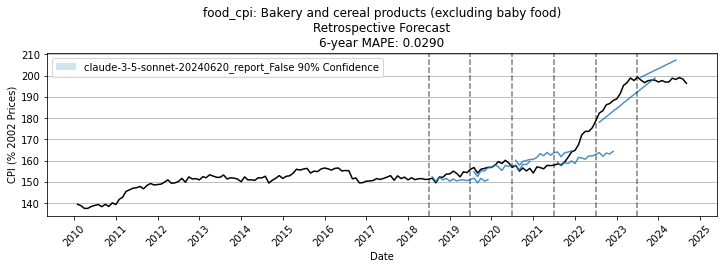

FileNotFoundError: [Errno 2] No such file or directory: '/fs01/home/kupfersk/cfpr_2025/generate_forecasts/output/experiment_analysis/plots/food_cpi: Bakery and cereal products (excluding baby food)_best_ensemble_forecast.png'

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cutoff_dates = report_sim_dates

for index, (category, top_experiment, mean_score, std_score) in best_results_year_df.iterrows():
    ensemble_experiments = top_experiment.split('+')

    ensemble_forecast_data = []

    for ensemble_experiment in ensemble_experiments:
        forecast_dfs = []
        for date in cutoff_dates:
            forecast_csv_path = f"./output/Full_Report/{ensemble_experiment}/random_seed_{random_seed}/{date}/forecasts/{category}.csv"
            forecast_df = pd.read_csv(forecast_csv_path, index_col=0).iloc[-18:]
            forecast_df.index = pd.to_datetime(forecast_df.index)
            forecast_dfs.append(forecast_df)

        ensemble_forecast_data.append((ensemble_experiment, forecast_dfs))

    context_df = foodprice_df.loc[(foodprice_df.index > "2010-01-01") & (foodprice_df.index <= cutoff_dates[0])][category]
    actual_df = foodprice_df.loc[foodprice_df.index >= cutoff_dates[0]][category]

    save_path = f"./output/experiment_analysis/plots/{category}_best_ensemble_forecast.png"  # Replace with the actual path if you're saving plots

    # plot for multiple ensemble methods, including the mean forecast if applicable
    plot_quantile_forecasts_multiple(category, context_df, ensemble_forecast_data, actual_df, cutoff_dates, model_name=f"6-year MAPE: {mean_score:.4f}", save_path=save_path, plot_mean=False)

In [ ]:
results = []
# Iterate through each row in best_results_year_df (Table 1)
for _, best_row in best_results_year_df.iterrows():
    category = best_row['category']
    top_experiment = best_row['top_experiment']
    mean_score_best = best_row['mean_score']
    
    # Find matching rows in mape_df (Table 2) based on category
    matching_rows = mape_df[mape_df['category'] == category]
    
    # Iterate through matching rows and check if the experiment matches the top_experiment
    for _, mape_row in matching_rows.iterrows():
        if top_experiment in mape_row['experiment']:
            if mean_score_best == mape_row['mean_score']:
                if category == mape_row['category']:

                    # Store the result (category, top_experiment, mean_score, etc.)
                    results.append({
                        'category': category,
                        'top_experiment': top_experiment,
                        'mean_score_best': best_row['mean_score'],
                        'mean_score_mape': mape_row['mean_score'],
                        'std_score': mape_row['std_score'],
                        'scores': mape_row['scores']
                    })
                    break

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

In [ ]:
results_df

# Plot quantile forecasts for each category

In [ ]:
# Assuming your DataFrame is named 'df' and the column with MAPE lists is 'scores'
# Create a new DataFrame to store the expanded columns for each evaluation window
expanded_df = pd.DataFrame()

# Loop through each row in the original DataFrame
for index, row in results_df.iterrows():
    mape_list = row['scores']  # Assuming the column with MAPE lists is named 'scores'
    
    # Create a dictionary for the new row
    new_row = {
        'experiment': row['top_experiment'],    # Retain experiment name
        'category': row['category'],        # Retain category
        'scores': row['scores']                 # Retain path
    }
    
    # Add each evaluation window's score as a new column
    for i, score in enumerate(mape_list):
        new_row['eval_window_'+report_sim_dates[i]] = score
    
    # Append the new row to the expanded DataFrame
    expanded_df = expanded_df.append(new_row, ignore_index=True)
expanded_df


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_category(df, category):

    # Assuming `expanded_df` is the DataFrame from the previous step with columns for each evaluation window
    #Set the index to 'experiment' for better visualization
    df.set_index('experiment', inplace=True)
    
    # Select only the columns related to evaluation windows (eval_window_0, eval_window_1, ...)
    eval_columns = [col for col in df.columns if 'eval_window_' in col]

    # Create the heatmap using seaborn
    plt.figure(figsize=(15, 12))  # Adjust the size of the heatmap as needed
    sns.heatmap(df[eval_columns], annot=True, cmap='coolwarm', linewidths=0.5)

    # Set the title and labels
    plt.title(f'Heatmap of Evaluation Window Scores For {category} Across Experiments', fontsize=16)
    plt.xlabel('Evaluation Windows')
    plt.ylabel('Experiment')

    # Show the heatmap
    plt.show()

In [ ]:
for category in target_categories:
    df_filt = expanded_df.sort_values('experiment').loc[expanded_df['category']==category]
    plot_category(df_filt, category)

In [ ]:
expanded_df.sort_values('experiment')